In [ ]:
import os
import random
import time
import datetime
import glob
import copy

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

from torchvision import datasets, transforms, models
import torchvision.io as io
from torchvision.transforms import v2
from torchvision import tv_tensors

from torchmetrics import MetricCollection
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall

import albumentations as A
from albumentations.pytorch import ToTensorV2

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

import segmentation_models_pytorch as smp

images/nazwa_pliku.png | (448, 448) | unit8 \
masks/nazwa_pliku_mask.png | (448, 448) | unit8 \
raw/nazwa_pliku_raw.npy | (448, 448) | float32

In [2]:
print(f"A: {A.__version__} (wymagane 2.0.8)")
print(f"smp: {smp.__version__} (wymagane 0.5.0)")

if torch.cuda.is_available():
    print("Cuda is available, using GPU")
else:
    print("Cuda is not available, using CPU")

A: 2.0.8 (wymagane 2.0.8)
smp: 0.5.0 (wymagane 0.5.0)
Cuda is not available, using CPU


In [23]:
"""
Model: wool_seg_v1
Indeksy walidacyjne:
 [90, 13, 20, 56, 110, 83, 45, 55, 8, 34, 101, 57, 71, 84, 53, 73, 76, 107, 38, 72, 28, 64, 54, 31]
"""
validation_indices = [90, 13, 20, 56, 110, 83, 45, 55, 8, 34, 101, 57, 71, 84, 53, 73, 76, 107, 38, 72, 28, 64, 54, 31]

In [ ]:
NUM_EPOCHS = 200
RS = 42
BATCH_SIZE = 8
NUM_WORKERS = 2
IMAGE_SIZE = 448


path_to_dataset = 'wool_defects_segmentation_dataset'
path_to_train_images_folder = path_to_dataset + "/train/raw"
path_to_train_masks_folder = path_to_dataset + "/train/masks"
L.seed_everything(RS)

os.makedirs("models", exist_ok=True)
os.makedirs("runs", exist_ok=True)

Seed set to 42


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir=None, transform=None):
        """
        Klasa Dataset do obrazów w formacie .npy i maski w formacie .png
        Transformacje Albumentation
        masks_dir=None dla ewaluacji na zbiorze testowym
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        self.image_files = sorted(glob.glob(os.path.join(images_dir, "*.npy")))

        if masks_dir and os.path.exists(masks_dir):
            self.mask_files = sorted(glob.glob(os.path.join(masks_dir, "*.png")))
            if len(self.image_files) != len(self.mask_files):
                print(f"Uwaga: Nierówna liczba plików! Obrazy: {len(self.image_files)}, Maski: {len(self.mask_files)}")
        else:
            self.mask_files = None

    def __len__(self):
        return len(self.image_files)


    def __getitem__(self, idx):
        img_np = np.load(self.image_files[idx], mmap_mode='r').astype(np.float32)
        
        # Albumentations wymaga formatu (H,W,C). 
        if img_np.ndim == 2:
            img_np = np.expand_dims(img_np, axis=2)


        if self.mask_files is not None:
            mask_np = cv2.imread(self.mask_files[idx], cv2.IMREAD_GRAYSCALE)
        else:
            mask_np = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.uint8)
        

        if self.transform:
            augmented = self.transform(image=img_np, mask=mask_np)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(img_np).permute(2, 0, 1) # (H,W,C) -> (C,H,W)
            mask = torch.from_numpy(mask_np).long()

        if isinstance(mask, torch.Tensor):
            mask = mask.long()
        
        return image, mask

In [4]:
calc_mean_std = False

if calc_mean_std:
    clear_transform = A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE),
        ToTensorV2()
    ])

    clear_dataset = SegmentationDataset(path_to_train_images_folder, path_to_train_masks_folder, transform=clear_transform)
    clear_loader = DataLoader(clear_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    data_sum_batch_mean = 0
    data_squared_sum_batch_mean = 0
    batches_sum = 0

    for image, mask in clear_loader:
        batches_sum += 1
        data_sum_batch_mean += torch.mean(image, dim=[0,2,3])
        data_squared_sum_batch_mean += torch.mean(image**2, dim=[0,2,3])

    mean = data_sum_batch_mean / batches_sum
    std = (data_squared_sum_batch_mean / batches_sum - mean**2) ** 0.5
else:
    mean = torch.tensor([1612.3043])
    std = torch.tensor([622.0490])


print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([1612.3043])
Std: tensor([622.0490])


In [5]:
### Zwykłe transformacje ###
# transform_train = v2.Compose([
#     v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
#     v2.RandomHorizontalFlip(0.5),
#     v2.RandomVerticalFlip(0.5),
#     v2.RandomAffine(
#         degrees=180,
#         translate=(0.05, 0.05),
#         scale=(0.9, 1.1),
#         shear=5,
#     ),
#     v2.RandomChoice([
#         v2.ColorJitter(brightness=0.2, contrast=0.2),
#         v2.Identity() 
#     ]),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=mean, std=std)
# ])

# transform_val_test = v2.Compose([
#     v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
#     v2.ToImage(),
#     v2.ToDtype(torch.float32, scale=True),
#     v2.Normalize(mean=mean, std=std)
# ])


### Transformacje z albumentation ###
transform_train_A = A.Compose([
    # Transformacje geometryczne
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(translate_percent=(-0.05, 0.05),scale=(0.9, 1.1),rotate=(-180, 180),shear=(-5, 5),p=0.7),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    
    # Transformacje obrazowe
    A.OneOf([
        A.GaussNoise(std_range=(0.02, 0.05)),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1)),
    ], p=0.5),

    A.Normalize(mean=[mean], std=[std], max_pixel_value=1.0),
    ToTensorV2() # (H, W, C) -> (C, H, W)
])
 
transform_val_A = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    A.Normalize(mean=[mean], std=[std], max_pixel_value=1.0),
    ToTensorV2()
])

In [ ]:
dataset = SegmentationDataset(path_to_train_images_folder, path_to_train_masks_folder)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_split, val_split = random_split(dataset, [train_size, val_size])

### nie używać subsetu, bo nie separuje danych przy transformacji
# train_dataset = Subset(train_dataset, train_split.indices)
# val_dataset = Subset(val_dataset, val_split.indices)

train_dataset = copy.copy(train_split)
train_dataset.dataset = copy.copy(dataset)
train_dataset.dataset.transform = transform_train_A

val_dataset = copy.copy(val_split)
val_dataset.dataset = copy.copy(dataset)
val_dataset.dataset.transform = transform_val_A


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [16]:
print("Indeksy walidacyjne:\n", val_split.indices)

Indeksy walidacyjne:
 [90, 13, 20, 56, 110, 83, 45, 55, 8, 34, 101, 57, 71, 84, 53, 73, 76, 107, 38, 72, 28, 64, 54, 31]


In [ ]:
# ============================================================================
# FUNKCJE STRAT (LOSS FUNCTIONS)
# ============================================================================

class DiceLoss(nn.Module):
    def __init__(self, smooth: float = 1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(logits)
        
        # Spłaszczenie do (N, H*W)
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1).float()
        
        intersection = (probs_flat * targets_flat).sum(dim=1)
        union = probs_flat.sum(dim=1) + targets_flat.sum(dim=1)
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice.mean()


class TverskyLoss(nn.Module):
    """
    alpha > beta -> większa kara za false negatives (pomijanie defektów)
    alpha < beta -> większa kara za false positives
    """
    def __init__(self, alpha: float = 0.7, beta: float = 0.3, smooth: float = 1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(logits)
        
        probs_flat = probs.view(probs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1).float()
        
        tp = (probs_flat * targets_flat).sum(dim=1)
        fp = ((1 - targets_flat) * probs_flat).sum(dim=1)
        fn = (targets_flat * (1 - probs_flat)).sum(dim=1)
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fn + self.beta * fp + self.smooth)
        return 1.0 - tversky.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        bce = F.binary_cross_entropy_with_logits(logits, targets.float(), reduction='none')
        probs = torch.sigmoid(logits)
        
        pt = torch.where(targets == 1, probs, 1 - probs)
        focal_weight = self.alpha * (1 - pt) ** self.gamma
        
        return (focal_weight * bce).mean()


class CombinedLoss(nn.Module):
    """
    - BCE + Dice 
    - Focal + Tversky
    """
    def __init__(
        self,
        loss_type: str = "bce_dice",  # "bce_dice" / "focal_tversky"
        bce_weight: float = 0.5,
        dice_weight: float = 0.5,
        focal_weight: float = 0.5,
        tversky_weight: float = 0.5,
        tversky_alpha: float = 0.7,
        tversky_beta: float = 0.3,
    ):
        super().__init__()
        self.loss_type = loss_type
        
        if loss_type == "bce_dice":
            self.bce = nn.BCEWithLogitsLoss()
            self.dice = DiceLoss()
            self.w1 = bce_weight
            self.w2 = dice_weight
        else: # "focal_tversky"
            self.focal = FocalLoss()
            self.tversky = TverskyLoss(alpha=tversky_alpha, beta=tversky_beta)
            self.w1 = focal_weight
            self.w2 = tversky_weight

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        if self.loss_type == "bce_dice":
            return self.w1 * self.bce(logits, targets.float()) + self.w2 * self.dice(logits, targets)
        else:
            return self.w1 * self.focal(logits, targets) + self.w2 * self.tversky(logits, targets)


# ============================================================================
# POST-PROCESSING
# ============================================================================

def remove_small_blobs(mask: np.ndarray, min_area: int = 50) -> np.ndarray:
    mask_uint8 = (mask * 255).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
    
    cleaned = np.zeros_like(mask_uint8)
    for i in range(1, num_labels):  # pomijanie tła (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            cleaned[labels == i] = 255
    
    return (cleaned / 255).astype(np.float32)


def morphological_closing(mask: np.ndarray, kernel_size: int = 3) -> np.ndarray:
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    return (closed / 255).astype(np.float32)


def postprocess_mask(mask: np.ndarray, min_blob_area: int = 50, closing_kernel: int = 3) -> np.ndarray:
    """
    postprocess:
    closing + usuwanie blobów
    """
    mask = morphological_closing(mask, kernel_size=closing_kernel)
    mask = remove_small_blobs(mask, min_area=min_blob_area)
    return mask


# ============================================================================
# MODEL LIGHTNING
# ============================================================================

class WoolDefectSegmentationModel(L.LightningModule):
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_weights: str = "imagenet",
        in_channels: int = 1,
        loss_type: str = "bce_dice",
        learning_rate: float = 1e-4,
        weight_decay: float = 1e-4,
        # Parametry postprocessingu
        postprocess_every_n_epochs: int = 5,
        min_blob_area: int = 50,
        closing_kernel: int = 3,
        # Parametry odmrażania enkodera
        freeze_encoder_epochs: int = 10,  # Ile epok trzymać enkoder zamrożony
        gradual_unfreeze: bool = True,    # Czy stopniowo odmrażać
        unfreeze_schedule: list = None,   # Harmonogram odmrażania
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Parametry odmrażania enkodera
        self.freeze_encoder_epochs = freeze_encoder_epochs
        self.gradual_unfreeze = gradual_unfreeze
        self.unfreeze_schedule = unfreeze_schedule or [(10, 2), (20, -1)]
        self._encoder_frozen = False
        

        self.model = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=1,
            activation=None,  # logity, bez sigmoidu 
        )
        

        if encoder_weights is not None and freeze_encoder_epochs > 0:
            self._freeze_encoder()
        
        self.criterion = CombinedLoss(loss_type=loss_type)
        
        self.train_metrics = MetricCollection({
            "train_f1": BinaryF1Score(),
            "train_precision": BinaryPrecision(),
            "train_recall": BinaryRecall(),
        })
        
        self.val_metrics = MetricCollection({
            "val_f1": BinaryF1Score(),
            "val_precision": BinaryPrecision(),
            "val_recall": BinaryRecall(),
        })
        
        self.val_postprocess_metrics = MetricCollection({
            "val_pp_f1": BinaryF1Score(),
            "val_pp_precision": BinaryPrecision(),
            "val_pp_recall": BinaryRecall(),
        })
        
        self.train_iou = MeanIoU(num_classes=2)
        self.val_iou = MeanIoU(num_classes=2)
        self.val_pp_iou = MeanIoU(num_classes=2)
        
        # Parametry post-processingu
        self.postprocess_every_n_epochs = postprocess_every_n_epochs
        self.min_blob_area = min_blob_area
        self.closing_kernel = closing_kernel


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


    def _freeze_encoder(self):
        for param in self.model.encoder.parameters():
            param.requires_grad = False
        self._encoder_frozen = True
        print(f"[Epoch {self.current_epoch}] Enkoder zamrożony.")


    def _get_encoder_blocks(self):
        """
        Zwraca listę bloków enkodera (od najgłębszego do najpłytszego).
        Dla ResNet: layer4, layer3, layer2, layer1, conv1
        """
        encoder = self.model.encoder
        blocks = []
        
        for name in ['layer4', 'layer3', 'layer2', 'layer1', 'conv1']:
            if hasattr(encoder, name):
                blocks.append(getattr(encoder, name))
        
        return blocks


    def _unfreeze_encoder_blocks(self, n_blocks: int):
        """
        Odmraża ostatnie n bloków enkodera (od najgłębszego).
        n_blocks=-1 oznacza odmrożenie wszystkich.
        """
        blocks = self._get_encoder_blocks()
        
        if n_blocks == -1:
            # Odmroź wszystko
            for param in self.model.encoder.parameters():
                param.requires_grad = True
            self._encoder_frozen = False
            print(f"[Epoch {self.current_epoch}] Cały enkoder odmrożony.")
        else:
            # Odmroź ostatnie n bloków
            for block in blocks[:n_blocks]:
                for param in block.parameters():
                    param.requires_grad = True
            print(f"[Epoch {self.current_epoch}] Odmrożono {n_blocks} ostatnich bloków enkodera.")


    def on_train_epoch_start(self):
        """
        Obsługuje stopniowe odmrażanie enkodera.
        """
        if not self.gradual_unfreeze or not self._encoder_frozen:
            return
        
        current_epoch = self.current_epoch
        
        for epoch_threshold, n_blocks in self.unfreeze_schedule:
            if current_epoch == epoch_threshold:
                self._unfreeze_encoder_blocks(n_blocks)
                break


    def _shared_step(self, batch, batch_idx, stage: str):
        """Wspólna logika dla train/val/test."""
        images, masks = batch
        
        # model.forward()
        logits = self(images)  # (N, 1, H, W)
        
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)  # (N, H, W) -> (N, 1, H, W)
            
        # Normalizacja masek z [0, 255] do [0, 1]
        if masks.max() > 1:
            masks = masks / 255.0

        masks = masks.float()
        
        # Loss
        loss = self.criterion(logits, masks)
        
        # Predykcje binarne
        preds = (torch.sigmoid(logits) > 0.5).long()
        targets = masks.long()
        
        # Spłaszczenie do 1D dla metryk klasyfikacyjnych
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)
        
        return loss, preds, targets, preds_flat, targets_flat


    def training_step(self, batch, batch_idx):
        loss, preds, targets, preds_flat, targets_flat = self._shared_step(batch, batch_idx, "train")
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.train_metrics.update(preds_flat, targets_flat)
        self.train_iou.update(preds, targets)
        
        return loss


    def on_train_epoch_end(self):
        metrics = self.train_metrics.compute()
        for name, value in metrics.items():
            self.log(name, value, prog_bar=False)
        self.train_metrics.reset()
        
        iou = self.train_iou.compute()
        self.log("train_iou", iou, prog_bar=True)
        self.train_iou.reset()


    def validation_step(self, batch, batch_idx):
        loss, preds, targets, preds_flat, targets_flat = self._shared_step(batch, batch_idx, "val")
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        
        ### walidacja bez postprocessingu
        self.val_metrics.update(preds_flat, targets_flat)
        self.val_iou.update(preds, targets)
        
        #### walidacja z post-processingiem (co N epok)
        current_epoch = self.current_epoch
        if (current_epoch + 1) % self.postprocess_every_n_epochs == 0:
            # Post-processing na CPU (OpenCV)
            preds_np = preds.squeeze(1).cpu().numpy()  # (N, H, W)
            preds_pp = np.stack([
                postprocess_mask(p, self.min_blob_area, self.closing_kernel)
                for p in preds_np
            ])
            preds_pp_tensor = torch.from_numpy(preds_pp).long().to(self.device)
            
            preds_pp_flat = preds_pp_tensor.view(-1)
            self.val_postprocess_metrics.update(preds_pp_flat, targets_flat)
            self.val_pp_iou.update(preds_pp_tensor.unsqueeze(1), targets)
        
        return loss


    def on_validation_epoch_end(self):
        metrics = self.val_metrics.compute()
        for name, value in metrics.items():
            self.log(name, value, prog_bar=True)
        self.val_metrics.reset()
        
        iou = self.val_iou.compute()
        self.log("val_iou", iou, prog_bar=True)
        self.val_iou.reset()
        
        current_epoch = self.current_epoch
        if (current_epoch + 1) % self.postprocess_every_n_epochs == 0:
            pp_metrics = self.val_postprocess_metrics.compute()
            for name, value in pp_metrics.items():
                self.log(name, value, prog_bar=False)
            self.val_postprocess_metrics.reset()
            
            pp_iou = self.val_pp_iou.compute()
            self.log("val_pp_iou", pp_iou, prog_bar=False)
            self.val_pp_iou.reset()


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=10,
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        """
        Wykonuje predykcję dla batcha.
        Zwraca słownik z:
        - 'logits': surowe wyjście modelu
        - 'probs': prawdopodobieństwa (po sigmoid)
        - 'preds_raw': predykcje binarne BEZ post-processingu
        - 'preds_pp': predykcje binarne Z post-processingiem
        
        predictions = trainer.predict(model, dataloaders=test_loader)
        """
        # Batch może być (images,) lub (images, masks)
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch
        
        # model.forward()
        logits = self(images)  # (N, 1, H, W)
        probs = torch.sigmoid(logits)
        
        # Predykcje binarne (bez post-processingu)
        preds_raw = (probs > 0.5).float()
        
        # Post-processing na CPU
        preds_raw_np = preds_raw.squeeze(1).cpu().numpy()  # (N, H, W)
        preds_pp_np = np.stack([
            postprocess_mask(p, self.min_blob_area, self.closing_kernel)
            for p in preds_raw_np
        ])
        preds_pp = torch.from_numpy(preds_pp_np).unsqueeze(1).to(self.device)  # (N, 1, H, W)
        
        return {
            'logits': logits,
            'probs': probs,
            'preds_raw': preds_raw,
            'preds_pp': preds_pp,
        }


    def predict_with_postprocess(
        self,
        images: torch.Tensor,
        return_all: bool = False,
        min_blob_area: int = None,
        closing_kernel: int = None,
        threshold: float = 0.5,
    ):
        """
        images: Tensor obrazów (N, C, H, W)
        return_all: Jeśli True, zwraca dict z wszystkimi wynikami
        min_blob_area: Nadpisuje domyślną wartość (opcjonalne)
        closing_kernel: Nadpisuje domyślną wartość (opcjonalne)
        threshold: Próg binaryzacji (domyślnie 0.5)
        
        Returns:
            Jeśli return_all=False: tuple (preds_raw, preds_pp)
            Jeśli return_all=True: dict z logits, probs, preds_raw, preds_pp
        

        model.eval()
        with torch.no_grad():
            preds_raw, preds_pp = model.predict_with_postprocess(images, threshold=0.4)
        """

        blob_area = min_blob_area if min_blob_area is not None else self.min_blob_area
        kernel = closing_kernel if closing_kernel is not None else self.closing_kernel
        
        # model.forward()
        logits = self(images)
        probs = torch.sigmoid(logits)
        preds_raw = (probs > threshold).float()  # modyufdikowalny threshold zamiast sztywnego 0.5
        
        # Post-processing
        preds_raw_np = preds_raw.squeeze(1).cpu().numpy()
        preds_pp_np = np.stack([
            postprocess_mask(p, blob_area, kernel)
            for p in preds_raw_np
        ])
        preds_pp = torch.from_numpy(preds_pp_np).unsqueeze(1).to(images.device)
        
        if return_all:
            return {
                'logits': logits,
                'probs': probs,
                'preds_raw': preds_raw,
                'preds_pp': preds_pp,
            }
        else:
            return preds_raw, preds_pp


    def predict_with_tta(
        self,
        images: torch.Tensor,
        min_blob_area: int = None,
        closing_kernel: int = None,
        threshold: float = 0.5,
    ):
        """
        predykcja z kilku wersji obrazu, uśrednia prawdopodobieństwa z: 
        oryginału, obrotów (90°, 180°, 270°) i odbicia H.
        
        Args:
            images: Tensor obrazów (N, C, H, W)
            min_blob_area: Min. powierzchnia blobu (opcjonalne)
            closing_kernel: Rozmiar kernela closing (opcjonalne)
            threshold: Próg binaryzacji (domyślnie 0.5)
        
        Returns:
            tuple (preds_raw, preds_pp) - uśrednione predykcje
        
        Przykład użycia:
            model.eval()
            with torch.no_grad():
                preds_raw, preds_pp = model.predict_with_tta(images)
        """
        
        blob_area = min_blob_area if min_blob_area is not None else self.min_blob_area
        kernel = closing_kernel if closing_kernel is not None else self.closing_kernel
        
        probs_list = []
        
        # Oryginał
        logits = self(images)
        probs_list.append(torch.sigmoid(logits))
        
        # Obrót 90°
        img_90 = torch.rot90(images, k=1, dims=[2, 3])
        logits_90 = self(img_90)
        probs_90 = torch.rot90(torch.sigmoid(logits_90), k=-1, dims=[2, 3])
        probs_list.append(probs_90)
        
        # Obrót 180°
        img_180 = torch.rot90(images, k=2, dims=[2, 3])
        logits_180 = self(img_180)
        probs_180 = torch.rot90(torch.sigmoid(logits_180), k=-2, dims=[2, 3])
        probs_list.append(probs_180)
        
        # Obrót 270°
        img_270 = torch.rot90(images, k=3, dims=[2, 3])
        logits_270 = self(img_270)
        probs_270 = torch.rot90(torch.sigmoid(logits_270), k=-3, dims=[2, 3])
        probs_list.append(probs_270)
        
        # Odbicie poziome
        img_flip_h = torch.flip(images, dims=[3])
        logits_flip = self(img_flip_h)
        probs_flip = torch.flip(torch.sigmoid(logits_flip), dims=[3])
        probs_list.append(probs_flip)
        
        # Uśrednienie prawdopodobieństw
        avg_probs = torch.stack(probs_list).mean(dim=0)
        preds_raw = (avg_probs > threshold).float()
        
        # Post-processing
        preds_raw_np = preds_raw.squeeze(1).cpu().numpy()
        preds_pp_np = np.stack([
            postprocess_mask(p, blob_area, kernel)
            for p in preds_raw_np
        ])
        preds_pp = torch.from_numpy(preds_pp_np).unsqueeze(1).to(images.device)
        
        return preds_raw, preds_pp



--------
-------- 

# Parammetry treningu

--------
--------

In [ ]:
model_name = "wool_seg_v2"

model = WoolDefectSegmentationModel(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,              # obrazy jednowymiarowe
    loss_type="focal_tversky",       # bce_dice / focal_tversky
    learning_rate=1e-4,
    weight_decay=1e-4,
    postprocess_every_n_epochs=5,
    min_blob_area=50,
    closing_kernel=3,
    freeze_encoder_epochs=10,
    gradual_unfreeze=True,
    unfreeze_schedule=[(10, 2), (20,4), (30, -1)],  # Harmonogram odmrażania
)

# Current Date
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Logger TensorBoard
run_name = f"{model_name}_metrics_{date}"
logger = TensorBoardLogger("runs", name=run_name)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath="models",
    filename=f"{run_name}_{date}_{{epoch:02d}}_{{val_f1:.4f}}",   # podwójne {{}}
    monitor="val_f1", # val_f1
    mode="max",
    save_top_k=3,
)


early_stop_callbac = EarlyStopping(
    monitor="val_f1",
    patience=30,
    mode="max",
    verbose=True,
)

# Trainer
trainer = L.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="auto",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    gradient_clip_val=1.0,
    precision="16-mixed",  # bf16-mixed / 16-mixed / 32-true
)


/home/hampthamanta/code_workspace/venv312/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:508: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[Epoch 0] Enkoder zamrożony.


--------
-------- 

# Trening

--------
--------

In [ ]:
start_time = time.time()


### Trening nowego modelu
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

### zapisany model (kontynuacja treningu)
# trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader, ckpt_path="models/last.ckpt")


training_time_sec = time.time() - start_time
total_time_formatted = str(datetime.timedelta(seconds=training_time_sec))

print('\n'*3)
print("=============================================================")
print(f"Całkowity czas treningu: {total_time_formatted} (HH:MM:SS)")
print(f"Całkowity czas treningu (sekundy): {training_time_sec:.2f} s")
print("=============================================================")

##################################################################################
##################################################################################

In [ ]:
print(f"Best model path: {checkpoint_callback.best_model_path}")
print(f"Best model score: {checkpoint_callback.best_model_score}")
print(f"Run name: {model_name}_metrics_{date}")

In [ ]:
### Google Colab ###
if 0:
  from google.colab import files
  import shutil

  download_model_name = checkpoint_callback.best_model_path[9:]
  download_runs_name = f"/content/runs/{run_name}"

  files.download(download_model_name)
  shutil.make_archive('runs_backup', 'zip', download_runs_name)
  files.download('runs_backup.zip')

---------------
---------------

# Walidacja / strojenie post-processingu

---------------
---------------




In [12]:
runs_path = r"runs/wool_seg_v1"
# model_path = r"models/wool_seg_v1_metrics_2026-01-27_13-42-06_2026-01-27_13-42-06_epoch=120_val_f1=0.9444.ckpt"
# model_path = r"models/wool_seg_v2_metrics_2026-01-27_16-17-09_2026-01-27_16-17-09_epoch=64_val_f1=0.9313.ckpt"
model_path = r"models/wool_seg_v4_metrics_2026-01-27_16-42-13_2026-01-27_16-42-13_epoch=93_val_f1=0.9411.ckpt"


model = WoolDefectSegmentationModel.load_from_checkpoint(
    model_path,
    min_blob_area=50,
    closing_kernel=3,
)

inference_trainer = L.Trainer(
    accelerator="auto", 
    devices="auto",
    logger=False,
    enable_checkpointing=False,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[Epoch 0] Enkoder zamrożony.


In [24]:
val2_dataset_base = copy.copy(dataset)
val2_dataset_base.transform = transform_val_A
val2_dataset = Subset(val2_dataset_base, validation_indices)

val2_loader = DataLoader(
    val2_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Walidacja (out_of_memory)
# inference_trainer.validate(model, dataloaders=val2_loader)

# Predykcja (zwraca output z predict_step)
predictions = inference_trainer.predict(model, dataloaders=val2_loader)

/home/hampthamanta/code_workspace/venv312/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting: |          | 0/? [00:00<?, ?it/s]

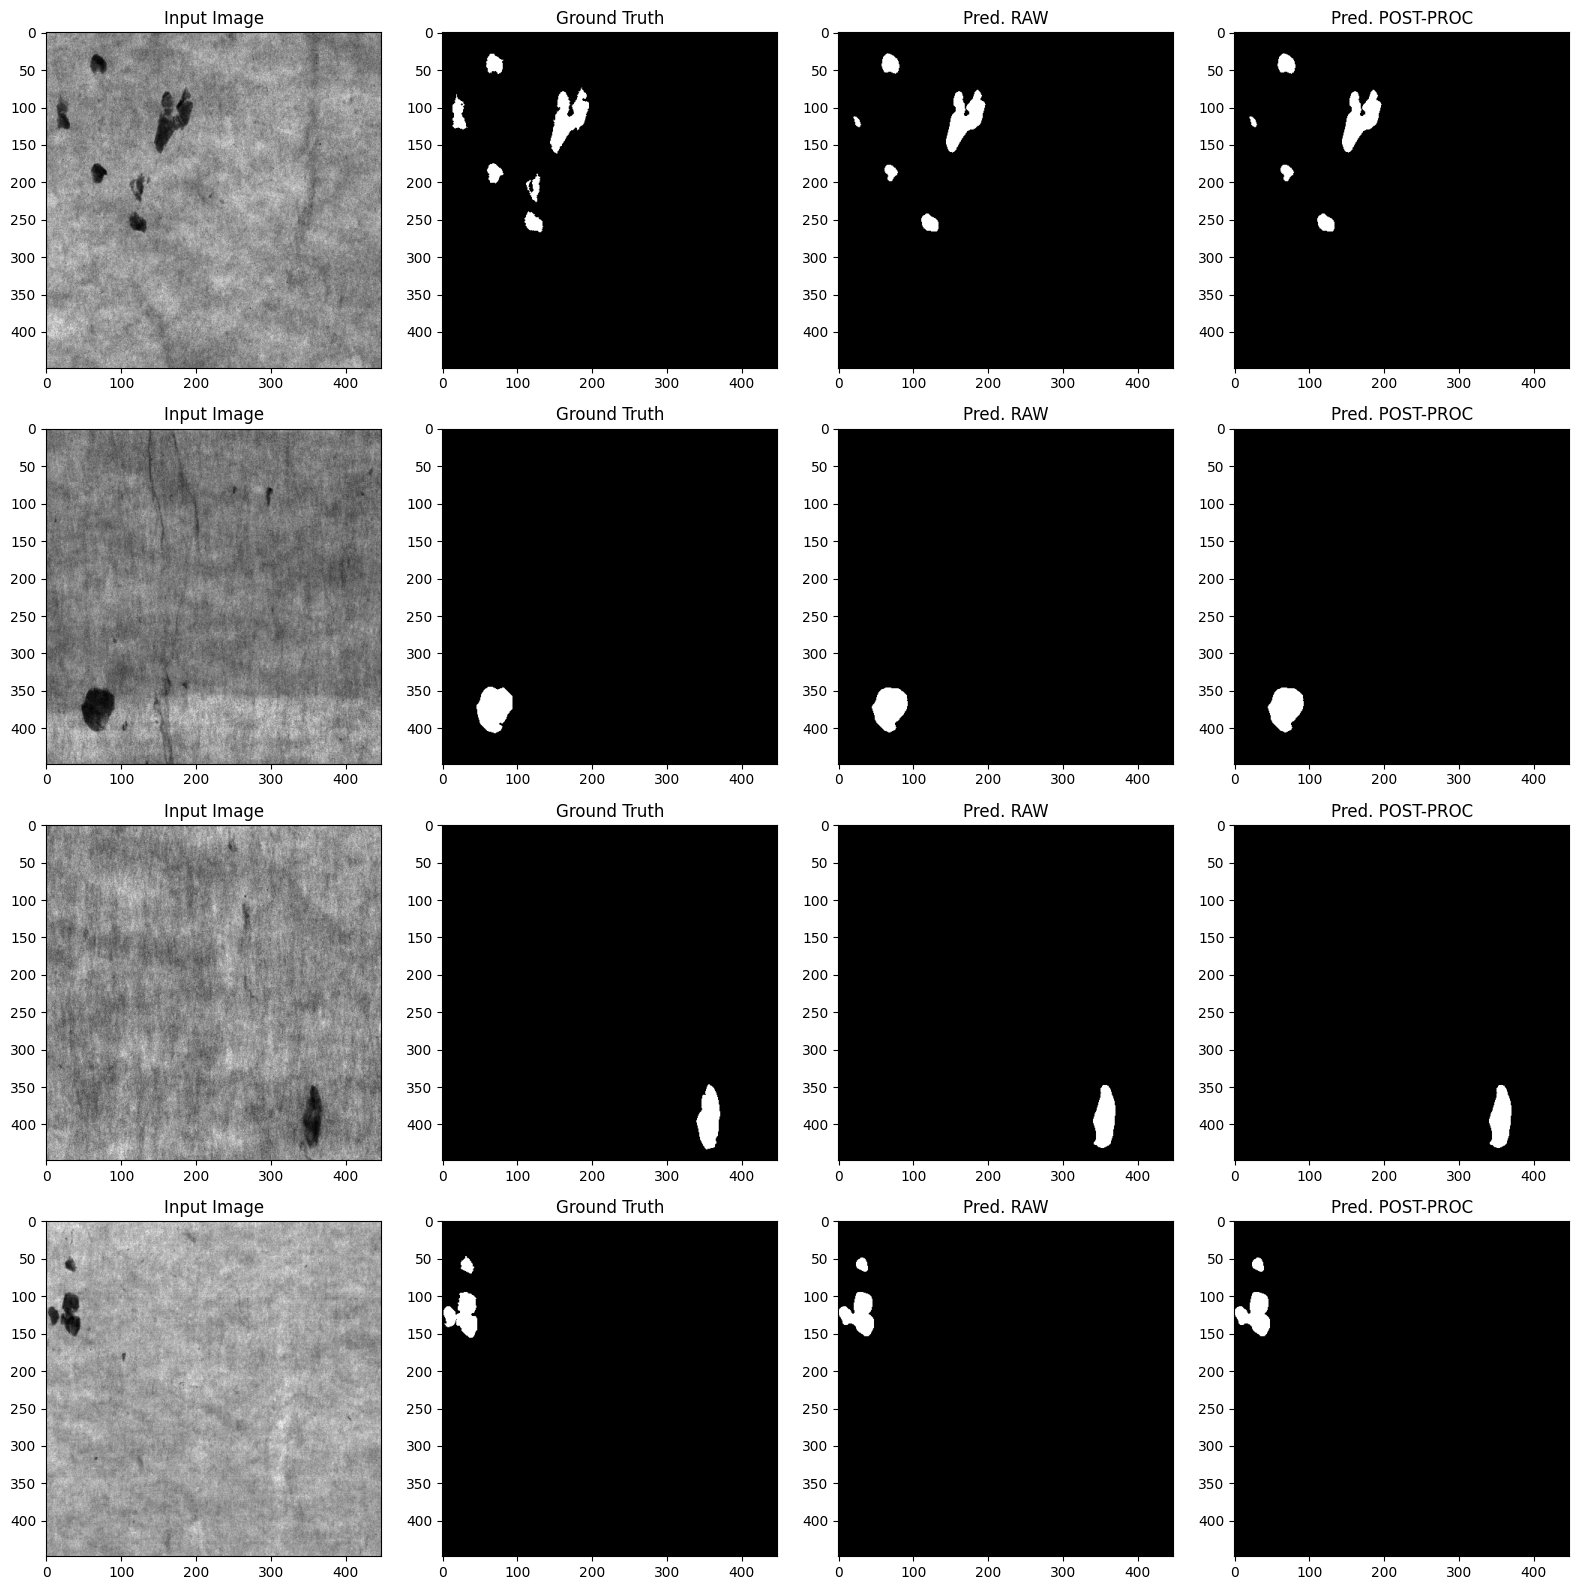


=== ŚREDNIE WYNIKI DLA ZBIORU WALIDACYJNEGO ===
F1 Score - RAW: 0.9312
F1 Score - PP:  0.9314
------------------------------
IoU      - RAW: 0.8112
IoU      - PP:  0.8119


In [ ]:
# Inicjalizacja metryk
f1_metric = BinaryF1Score().to(model.device)
iou_metric = MeanIoU(num_classes=2).to(model.device)
# Listy na wyniki
results = {
    "raw_f1": [], "pp_f1": [],
    "raw_iou": [], "pp_iou": []
}
model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(val2_loader):
        images = images.to(model.device)
        masks = masks.to(model.device)
        
        preds_raw, preds_pp = model.predict_with_postprocess(images)
        m_flat = (masks > 0.5).long().view(-1)
        
        results["raw_f1"].append(f1_metric(preds_raw.view(-1), m_flat).item())
        results["pp_f1"].append(f1_metric(preds_pp.view(-1), m_flat).item())
        
        m_iou = (masks > 0.5).long().unsqueeze(1)
        results["raw_iou"].append(iou_metric(preds_raw.long(), m_iou).item())
        results["pp_iou"].append(iou_metric(preds_pp.long(), m_iou).item())

        if i == 0: # tylko pierwszy batch
            n_samples = min(len(images), 4)
            fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4 * n_samples))
            
            for j in range(n_samples):
                axes[j, 0].imshow(images[j].cpu().squeeze(), cmap='gray')
                axes[j, 0].set_title("Input Image")
                
                axes[j, 1].imshow(masks[j].cpu().squeeze(), cmap='gray')
                axes[j, 1].set_title("Ground Truth")
                
                axes[j, 2].imshow(preds_raw[j].cpu().squeeze(), cmap='gray')
                axes[j, 2].set_title("Pred. RAW")
                
                axes[j, 3].imshow(preds_pp[j].cpu().squeeze(), cmap='gray')
                axes[j, 3].set_title("Pred. POST-PROC")
            
            plt.tight_layout()
            plt.show()

print("\n=== ŚREDNIE WYNIKI DLA ZBIORU WALIDACYJNEGO ===")
print(f"F1 Score - RAW: {sum(results['raw_f1'])/len(results['raw_f1']):.4f}")
print(f"F1 Score - PP:  {sum(results['pp_f1'])/len(results['pp_f1']):.4f}")
print("-" * 30)
print(f"IoU      - RAW: {sum(results['raw_iou'])/len(results['raw_iou']):.4f}")
print(f"IoU      - PP:  {sum(results['pp_iou'])/len(results['pp_iou']):.4f}")

In [ ]:
"""
30
1
=== ŚREDNIE WYNIKI DLA ZBIORU WALIDACYJNEGO ===
F1 Score - RAW: 0.9444
F1 Score - PP:  0.9450
------------------------------
IoU      - RAW: 0.8870
IoU      - PP:  0.8882
"""

-----------
-----------

# Ewaluacja na zbiorze testowym i zapisanie wyników

-----------
-----------